In [4]:
gap_time = 1
#gap_time = 10  # gap time between each segment
win_size = [10, 30, 60]  # window size of each segment
step_max = 5 # maximum step of ConvLSTM


#raw_data_path = "output_file.csv"
raw_data_path = "minute_finally_transposed_resampled.csv"  # path to load raw data
#model_path = '../MSCRED/'
train_data_path = ""
test_data_path = ""
reconstructed_data_path = ""

'''
train_start_id = 10
train_end_id = 800

test_start_id = 800
test_end_id = 2000

valid_start_id = 800
valid_end_id = 1000
'''
train_start_id = 10
train_end_id = 4320

valid_start_id = 10
valid_end_id = 3000

test_start_id = 10
test_end_id = 4320


training_iters = 5
save_model_step = 1

learning_rate = 0.0002

threshold_default = 0.05
alpha = 1.5

In [3]:
import numpy as np
import pandas as pd
#import os


In [5]:
df =  pd.read_csv(raw_data_path, skiprows = 1, index_col = 0)
df

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,4310.0,4311.0,4312.0,4313.0,4314.0,4315.0,4316.0,4317.0,4318.0,4319.0
0,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
class SignatureMatrices:
    def __init__(self):

        #df = pd.read_csv(raw_data_path)
        #df_new = df.drop(labels=0, axis=1)
        self.raw_data = pd.read_csv(raw_data_path, skiprows = 1, index_col = 0)
        #print(self.raw_data)
        self.series_number = self.raw_data.shape[0]
        self.series_length = self.raw_data.shape[1]
        self.signature_matrices_number = int(self.series_length / gap_time)

        print("series_number is", self.series_number)
        print("series_length is", self.series_length)
        print("signature_matrices_number is", self.signature_matrices_number)

    def signature_matrices_generation(self, win):
        """
        Generation signature matrices according win_size and gap_time, the size of raw_data is n * T, n is the number of
        time series, T is the length of time series.
        To represent the inter-correlations between different pairs of time series in a multivariate time series segment
        from t − w to t, we construct an n × n signature matrix Mt based upon the pairwise inner-product of two time series
        within this segment.
        :param win: the length of the time series segment
        :return: the signature matrices
        """

        if win == 0:
            print("The size of win cannot be 0")

        raw_data = np.asarray(self.raw_data)
        signature_matrices = np.zeros((self.signature_matrices_number, self.series_number, self.series_number))

        for t in range(win, self.signature_matrices_number):
            raw_data_t = raw_data[:, t - win:t]
            signature_matrices[t] = np.dot(raw_data_t, raw_data_t.T) / win
            
        return signature_matrices

    def generate_train_test(self, signature_matrices):
        """
        Generate train and test dataset, and store them to ../data/train/train.npy and ../data/test/test.npy
        :param signature_matrices:
        :return:
        """
        train_dataset = []
        valid_dataset = []
        test_dataset = []

        for data_id in range(self.signature_matrices_number):
            index = data_id - step_max + 1
            #print('Index:', index)
            if data_id < train_start_id:
                continue
            index_dataset = signature_matrices[:, index:index + step_max]
            if data_id < train_end_id:
                train_dataset.append(index_dataset)
            if data_id >= valid_start_id and data_id < valid_end_id:
                valid_dataset.append(index_dataset)
                test_dataset.append(index_dataset)
            else:
                test_dataset.append(index_dataset)

        train_dataset = np.asarray(train_dataset)
        train_dataset = np.reshape(train_dataset, [-1, step_max, self.series_number, self.series_number,
                                                   signature_matrices.shape[0]])
        valid_dataset = np.asarray(valid_dataset)
        valid_dataset = np.reshape(valid_dataset, [-1, step_max,self.series_number, self.series_number,
                                                signature_matrices.shape[0]])
        test_dataset = np.asarray(test_dataset)
        test_dataset = np.reshape(test_dataset, [-1, step_max,self.series_number, self.series_number,
                                                signature_matrices.shape[0]])


        print("train dataset shape is", train_dataset.shape)
        print("valid dataset shape is", valid_dataset.shape)
        print("test dataset shape is", test_dataset.shape)

        train_path = ""
        #if not os.path.exists(train_path):
            #os.makedirs(train_path)
        train_path = "train.npy"

        valid_path = ""
        #if not os.path.exists(test_path):
            #os.makedirs(test_path)
        valid_path = "valid.npy"
        test_path = "test.npy"

        np.save(train_path, train_dataset)
        np.save(valid_path, valid_dataset)
        np.save(test_path, test_dataset)
        print(train_dataset[-1].shape)


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
Matrices = SignatureMatrices()
signature_matrices = []

    # Generation signature matrices according the win size w
for w in win_size:
    signature_matrices.append(Matrices.signature_matrices_generation(w))
#print(signature_matrices)   

signature_matrices = np.asarray(signature_matrices)
print("the shape of signature_matrices is", signature_matrices.shape)

    # Generate train and test dataset
Matrices.generate_train_test(signature_matrices)


series_number is 4
series_length is 4320
signature_matrices_number is 4320
the shape of signature_matrices is (3, 4320, 4, 4)
train dataset shape is (4310, 5, 4, 4, 3)
valid dataset shape is (2990, 5, 4, 4, 3)
test dataset shape is (4310, 5, 4, 4, 3)
(5, 4, 4, 3)


Данн

<AxesSubplot:>

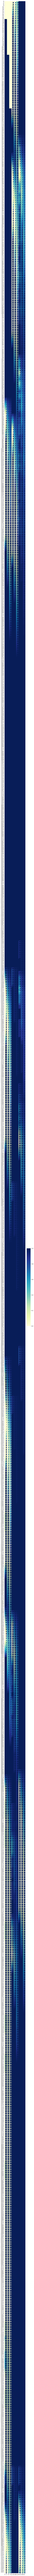

In [39]:
#fig, axes = plt.subplots(168, 12, figsize=(10, 150))
fig, axes = plt.subplots(1, 1, figsize=(4, 400))

global_min = np.min([np.min(matrix) for matrix in signature_matrices])
global_max = np.max([np.max(matrix) for matrix in signature_matrices])
new_big_matrix = np.zeros((3, 3, 5760, 4))
for i in range(3):
    for j in range(3):
        idx1 = i * 1440
        idx2 = (i + 1) * 1440
        #print(i, j)
        #print(idx1, idx2)
        new_big_matrix[i][j] = np.concatenate(signature_matrices[j][idx1:idx2], axis = 0)
result = np.concatenate(np.concatenate(new_big_matrix, axis = 0), axis = 1)
sns.heatmap(result, cmap="YlGnBu", vmin=global_min, vmax=global_max, annot=False) 


In [40]:
#import utils as util
import numpy as np
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [41]:
def cnn_encoder_layer(data, filter_layer, strides):
    result = tf.nn.conv2d(
        input=data,
        filters=filter_layer,
        strides=strides,
        padding="SAME")
    return tf.nn.selu(result)


def tensor_variable(shape, name):
    with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
        variable = tf.compat.v1.get_variable(name, shape=shape, initializer=tf.compat.v1.keras.initializers.glorot_uniform())
    return variable


def cnn_encoder(data):
    filter1 = tensor_variable([3, 3, 3, 32], "filter1")
    strides1 = (1, 1, 1, 1)
    cnn1_out = cnn_encoder_layer(data, filter1, strides1)
    
    
    filter2 = tensor_variable([3, 3, 32, 64], "filter2")
    strides2 = (1, 2, 2, 1)
    cnn2_out = cnn_encoder_layer(cnn1_out, filter2, strides2)
    
    
    return cnn1_out, cnn2_out


def cnn_lstm_attention_layer(input_data, layer_number):
    #outputs = tf.compat.v1.placeholder(tf.float32, [5, 30, 30, 32])
    convlstm_layer = tf.compat.v1.keras.layers.ConvLSTM2D( 
        filters=input_data.shape[-1],
        padding='same',
        kernel_size=(2, 2),
        use_bias=True,
        return_sequences=True,
        name="conv_lstm_cell" + str(layer_number))
    #print('!', convlstm_layer )
    outputs = convlstm_layer(input_data)
    attention_w = []
    for k in range(step_max):
        attention_w.append(tf.reduce_sum(tf.multiply(outputs[:, k], outputs[:, -1])) / step_max)
    attention_w = tf.reshape(tf.nn.softmax(tf.stack(attention_w)), [1, step_max])
    
    outputs = tf.reshape(outputs, [step_max, -1])
    
    # а вот это как раз та матрица, которая почему-то меньше нужного
    outputs = tf.matmul(attention_w, outputs)
    #ошибка в строке ниже
    
    outputs = tf.reshape(outputs, [1, input_data.shape[2], input_data.shape[3], input_data.shape[4]])

    return outputs, attention_w


def cnn_decoder_layer(conv_lstm_out_c, filter, output_shape, strides):
    deconv = tf.nn.conv2d_transpose(
        value=conv_lstm_out_c,
        filters=filter,
        output_shape=output_shape,
        strides=strides,
        padding="SAME")
    deconv = tf.nn.selu(deconv)
    return deconv


def cnn_decoder(lstm1_out, lstm2_out):
    
    '''
    d_filter2 = tensor_variable([3, 3, 32, 128], "d_filter2")
    dec2 = cnn_decoder_layer(lstm2_out, d_filter2, [1, 4, 4, 32], (1, 2, 2, 1))
    dec2_concat = tf.concat([dec2, lstm1_out], axis=3)
    '''
    d_filter1 = tensor_variable([3, 3, 3, 64], "d_filter1")
    dec1 = cnn_decoder_layer(lstm2_out, d_filter1, [1, 4, 4, 3], (1, 2, 2, 1))
    return dec1


In [42]:
matrix_data_path = train_data_path + "train.npy"
matrix_gt_1 = np.load(matrix_data_path)

data_input = tf.compat.v1.placeholder(tf.float32, [5, 4, 4, 3])

#conv1_out, conv2_out, conv3_out, conv4_out = cnn_encoder(data_input)
conv1_out, conv2_out = cnn_encoder(data_input)

#print(conv1_out.shape)
#print(conv2_out.shape)

conv1_out = tf.reshape(conv1_out, [ 1, 5, 4, 4, 32])
    
conv2_out = tf.reshape(conv2_out, [ 1, 5, 2, 2, 64])
#conv3_out = tf.reshape(conv3_out, [ 1, 5, 8, 8, 128])
#conv4_out = tf.reshape(conv4_out, [ 1, 5, 4, 4, 256])
conv1_lstm_attention_out, atten_weight_1 = cnn_lstm_attention_layer(conv1_out, 1)
 
#print('conv1_lstm_attention_out', conv1_lstm_attention_out)

#conv1_lstm_attention_out, atten_weight_1 = cnn_lstm_attention_layer(conv1_out, 1)
conv2_lstm_attention_out, atten_weight_2 = cnn_lstm_attention_layer(conv2_out, 2)

#print('conv2_lstm_attention_out', conv2_lstm_attention_out)

       
#conv3_lstm_attention_out, atten_weight_3 = cnn_lstm_attention_layer(conv3_out, 3)
#conv4_lstm_attention_out, atten_weight_4 = cnn_lstm_attention_layer(conv4_out, 4)
    
#deconv_out = cnn_decoder(conv1_lstm_attention_out, conv2_lstm_attention_out, conv3_lstm_attention_out,
                             #conv4_lstm_attention_out)

deconv_out = cnn_decoder(conv1_lstm_attention_out, conv2_lstm_attention_out)

#print(deconv_out.shape)

loss = tf.reduce_mean(tf.square(data_input[-1] - deconv_out))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
init = tf.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)

loss_value_list = []
for idx in range(train_start_id, train_end_id):
    matrix_gt = matrix_gt_1[idx - train_start_id]
    feed_dict = {data_input: np.asarray(matrix_gt)}
    a, loss_value = sess.run([optimizer, loss], feed_dict)
    print("mse of last train data: " + str(loss_value))
    loss_value_list.append(loss_value)
   
matrix_data_path = "valid.npy"
matrix_gt_1 = np.load(matrix_data_path)
result_all = []

for idx in range(valid_start_id, valid_end_id):
    matrix_gt = matrix_gt_1[idx - valid_start_id]
    feed_dict = {data_input: np.asarray(matrix_gt)}
    result, loss_value = sess.run([deconv_out, loss], feed_dict)
    result_all.append(result)
    print("mse of last valid data: " + str(loss_value))

        

reconstructed_path = reconstructed_data_path
#if not os.path.exists(reconstructed_path):
    #os.makedirs(reconstructed_path)
reconstructed_path = "valid_reconstructed.npy"

result_all = np.asarray(result_all).reshape((-1, 4, 4, 3))
np.save(reconstructed_path, result_all)

test_data_path = "test.npy"
matrix_test = np.load(test_data_path)
result_all_test = []

for idx in range(test_start_id, test_end_id):
    matrix_gt = matrix_test[idx - test_start_id]
    feed_dict = {data_input: np.asarray(matrix_gt)}
    result, loss_value = sess.run([deconv_out, loss], feed_dict)
    result_all_test.append(result)
    print("mse of last test data: " + str(loss_value))
reconstructed_test_path = "test_reconstructed.npy"
result_all_test = np.asarray(result_all_test).reshape((-1, 4, 4, 3))
np.save(reconstructed_test_path, result_all_test)


mse of last train data: 0.00038242814
mse of last train data: 0.00032817075
mse of last train data: 0.00035771265
mse of last train data: 0.00055923295
mse of last train data: 0.00039392663
mse of last train data: 0.00024699967
mse of last train data: 0.00016747911
mse of last train data: 0.00013307133
mse of last train data: 0.000116374926
mse of last train data: 0.00010539143
mse of last train data: 9.638601e-05
mse of last train data: 8.799945e-05
mse of last train data: 8.021898e-05
mse of last train data: 7.451709e-05
mse of last train data: 7.143019e-05
mse of last train data: 7.026502e-05
mse of last train data: 6.752988e-05
mse of last train data: 6.106191e-05
mse of last train data: 5.1886815e-05
mse of last train data: 4.2481497e-05
mse of last train data: 4.6562713e-05
mse of last train data: 7.293559e-05
mse of last train data: 6.666081e-05
mse of last train data: 5.9253183e-05
mse of last train data: 9.549964e-05
mse of last train data: 6.795299e-05
mse of last train data:

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import utils as util
import re

The shape of valid data is (2990, 4, 4, 3)
The shape of reconstructed valid data is (2990, 4, 4, 3)
Max valid anom is 16.00
Threshold is 24.00


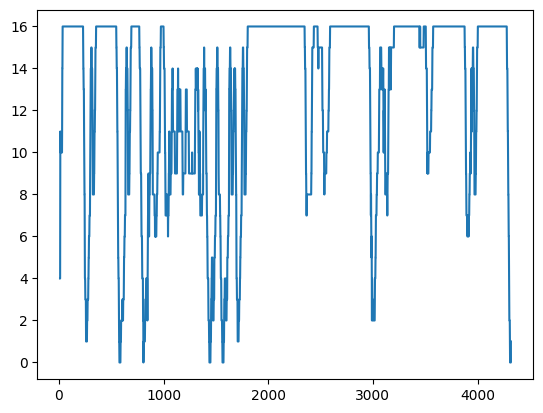

In [44]:
valid_anomaly_score = np.zeros((valid_end_id - valid_start_id, 1))
test_anomaly_score = np.zeros((test_end_id - test_start_id, 1))


valid_data = np.load("valid.npy")
valid_data = valid_data[:, -1, ...]  # only compare the last matrix with the reconstructed data
reconstructed_valid_data = np.load("valid_reconstructed.npy")
print("The shape of valid data is {}".format(valid_data.shape))
print("The shape of reconstructed valid data is {}".format(reconstructed_valid_data.shape))

valid_len = valid_end_id - valid_start_id

for i in range(valid_end_id - valid_start_id):
    '''
    np.subtract - поэлементное вычитание двух массивов
    Выполняется поэлементное вычитание массивов test_data и reconstructed_data
    Для каждой итерации цикла находится массив квадратов разностей между элемментами
    Элементов valid = 200
    Элементов test = 472
    '''

    error = np.square(np.subtract(valid_data[i, ..., 0], reconstructed_valid_data[i, ..., 0]))
    

    '''
    Создается массив индексов.
    Вычисляется количество элементов в полученном кластере индексов.
    '''
    threshold_array = np.full((4, 4), threshold_default)
    num_anom = np.sum(error > threshold_array) #np.where работает странно
    valid_anomaly_score[i] = num_anom

max_valid_anom = np.max(valid_anomaly_score)
threshold = max_valid_anom * alpha

print("Max valid anom is %.2f" % max_valid_anom)
print("Threshold is %.2f" % threshold)

test_data = np.load("test.npy")
test_data = test_data[:, -1, ...]  # only compare the last matrix with the reconstructed data
reconstructed_test_data = np.load("test_reconstructed.npy")

for i in range(test_end_id - test_start_id):
    error = np.square(np.subtract(test_data[i, ..., 0], reconstructed_test_data[i, ..., 0]))
    threshold_array = np.full((4, 4), threshold_default)
    num_anom = np.sum(error > threshold_array)
    test_anomaly_score[i] = num_anom

x_ces = np.arange(10, 4320)
plt.plot(x_ces, test_anomaly_score)
plt.show()

